Dataset

In [1]:
import sys
sys.path.append("..")

from src import dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary

import optuna

In [2]:
df = dataset.process_metadata("clear_2018/clear_2018.csv")
df

Unnamed: 0    user         ROI                                    sen2  \
0            55  ANDREA  point_0502  20180316T103021_20180316T103018_T33VWJ   
1            70  ANDREA  point_0511  20180404T092031_20180404T092028_T36VVP   
2           190  ANDREA  point_0564  20180204T112249_20180204T112254_T29TNE   
3           205  ANDREA  point_0573  20181220T051219_20181220T051613_T44RQS   
4           415  ANDREA  point_0839  20181215T074319_20181215T074319_T38RPV   
..          ...     ...         ...                                     ...   
203        9940   WENDY  point_8417  20181222T082341_20181222T083220_T35PQP   
204        9960   CESAR  point_8945  20180705T100031_20180705T100508_T33TWL   
205        9980   WENDY  point_9976  20181217T055231_20181217T055231_T43SDR   
206        9985   WENDY  point_9980  20181217T055231_20181217T055231_T42SYA   
207        9990   WENDY  point_9981  20181217T055231_20181217T055231_T42SYA   

     cloud_per cloud_coverage     sensing_time  year  \
0          0.0     cloud-free  20180316T103021  2018   
1          0.0     cloud-free  20180404T092031  2018   
2          0.0     cloud-free  20180204T112249  2018   
3          0.0     cloud-free  20181220T051219  2018   
4          0.0     cloud-free  20181215T074319  2018   
..         ...            ...              ...   ...   
203        0.0     cloud-free  20181222T082341  2018   
204        0.0     cloud-free  20180705T100031  2018   
205        0.0     cloud-free  20181217T055231  2018   
206        0.0     cloud-free  20181217T055231  2018   
207        0.0     cloud-free  20181217T055231  2018   

                                                  path  
0    clear_2018/point_0502/20180316T103021_20180316...  
1    clear_2018/point_0511/20180404T092031_20180404...  
2    clear_2018/point_0564/20180204T112249_20180204...  
3    clear_2018/point_0573/20181220T051219_20181220...  
4    clear_2018/point_0839/20181215T074319_20181215...  
..                                                 ...  
203  clear_2018/point_8417/20181222T082341_20181222...  
204  clear_2018/point_8945/20180705T100031_20180705...  
205  clear_2018/point_9976/20181217T055231_20181217...  
206  clear_2018/point_9980/20181217T055231_20181217...  
207  clear_2018/point_9981/20181217T055231_20181217...  

[208 rows x 9 columns]

In [3]:
df_train = df.sample(frac=0.6)
df_test = df.loc[~df.index.isin(df_train.index)]

In [4]:
len(df_train), len(df_test)

(125, 83)

In [5]:
any(item in df_test.index for item in df_train.index)

False

In [6]:
ds_train = dataset.TiffDataset(df_train, 256, True)
len(ds_train)

125

94


Text(0.5, 1.0, 'L2A')

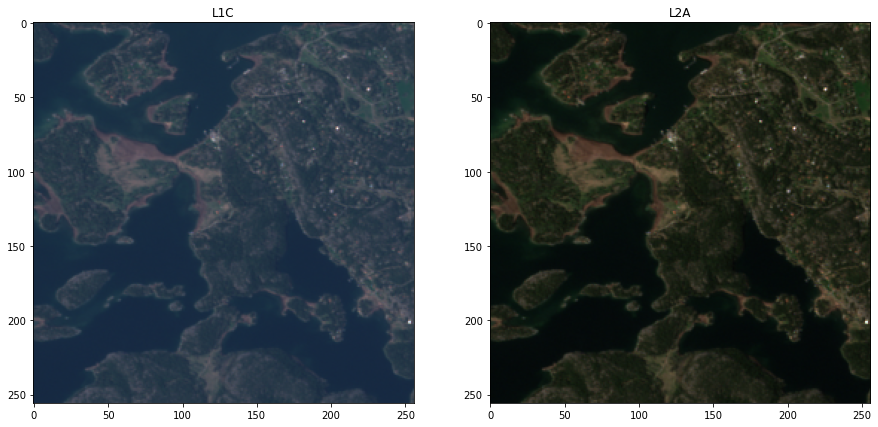

In [7]:
idx = np.random.randint(0,len(ds_train))
print(idx)
item = ds_train[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

Models

U-NET

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class UNET(nn.Module):
    def __init__(self, in_channels=13, out_channels=14, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="relu", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="relu", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [9]:
model = UNET()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          13,376
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
              ReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
              ReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
             ReLU-13          [-1, 512, 16, 16]               0
            Block-14          [-1, 512,

In [10]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = UNET()
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


FCNN

In [11]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        # Learnable layers
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=14, kernel_size=5, padding=2)


    def forward(self, x):
        # x.size() = (N, 13, W, W) 
        x = F.relu(self.conv1(x)) 
        # x.size() = (N, 32, W, W) 
        x = F.relu(self.conv2(x))
        # x.size() = (N, 64, W, W)  
        x = F.relu(self.conv3(x))
        # x.size() = (N, 32, W, W)
        x = self.conv4(x)
        # x.size() = (N, 14, W, W)
        return x

In [12]:
model = FCNN()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           3,776
            Conv2d-2         [-1, 64, 256, 256]          18,496
            Conv2d-3         [-1, 32, 256, 256]          18,464
            Conv2d-4         [-1, 14, 256, 256]          11,214
Total params: 51,950
Trainable params: 51,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.25
Forward/backward pass size (MB): 71.00
Params size (MB): 0.20
Estimated Total Size (MB): 74.45
----------------------------------------------------------------


In [13]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = FCNN()
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


Hyperparameter Tunning

[I 2022-04-09 13:48:36,614] A new study created in memory with name: no-name-5f388545-fcde-4066-9456-d28308c193c2
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:26<00:00, 45.76s/it]


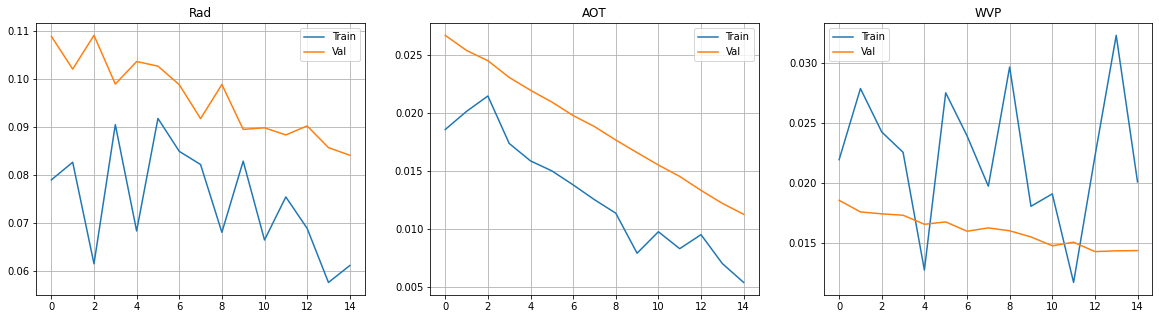

[I 2022-04-09 14:00:03,560] Trial 0 finished with value: 0.10429757088422775 and parameters: {'alpha': 0.9786154556524126, 'beta': 0.6467925393282776, 'lr': 3.7641368725351116e-05}. Best is trial 0 with value: 0.10429757088422775.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:26<00:00, 45.74s/it]


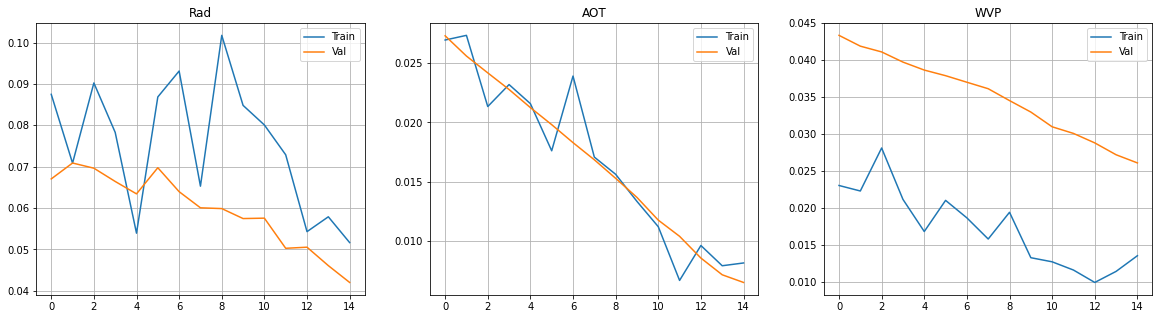

[I 2022-04-09 14:11:30,016] Trial 1 finished with value: 0.053350359201431274 and parameters: {'alpha': 0.6106264124272579, 'beta': 0.2828084664010435, 'lr': 7.301266827421476e-05}. Best is trial 1 with value: 0.053350359201431274.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:28<00:00, 45.88s/it]


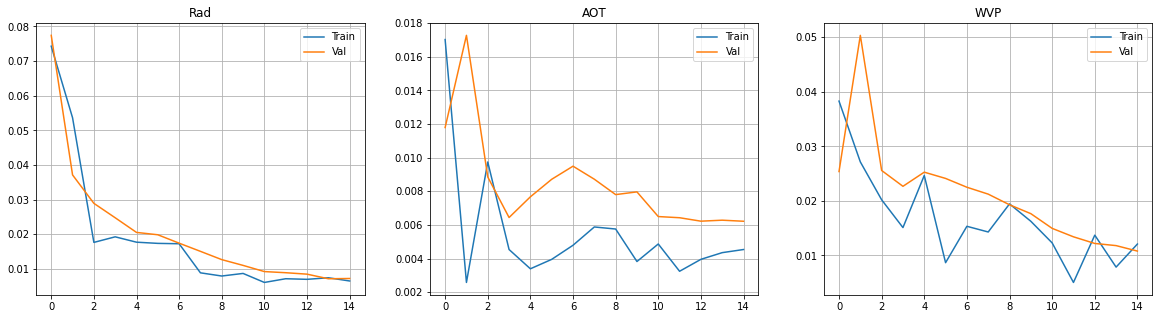

[I 2022-04-09 14:22:58,627] Trial 2 finished with value: 0.017518896609544754 and parameters: {'alpha': 0.30813059847743485, 'beta': 0.7755951703006763, 'lr': 0.0009432422267505336}. Best is trial 2 with value: 0.017518896609544754.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:27<00:00, 45.82s/it]


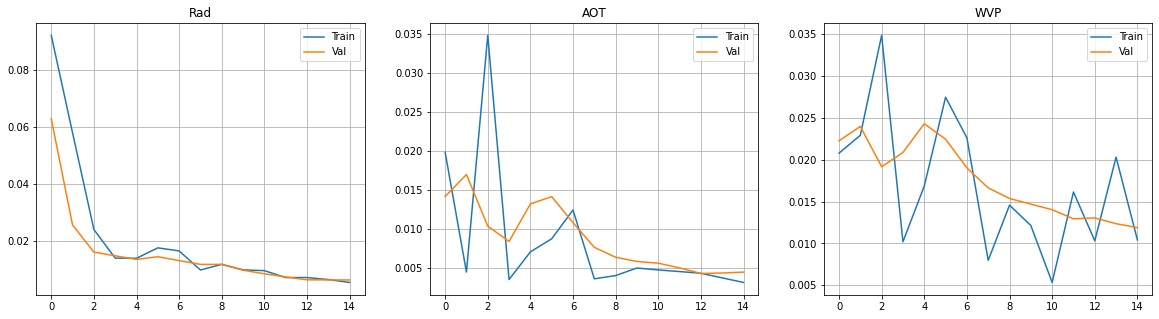

[I 2022-04-09 14:34:26,348] Trial 3 finished with value: 0.016549628227949142 and parameters: {'alpha': 0.9075653154732716, 'beta': 0.5301136408744364, 'lr': 0.000829354460589568}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:31<00:00, 46.13s/it]


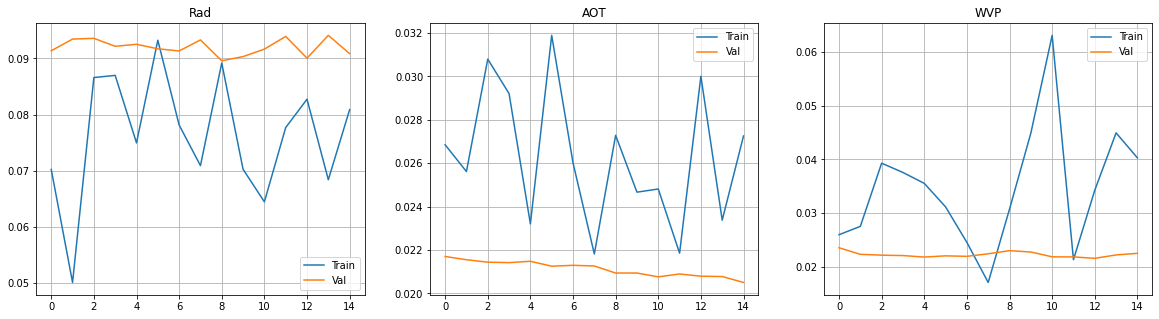

[I 2022-04-09 14:45:58,686] Trial 4 finished with value: 0.1277776062488556 and parameters: {'alpha': 0.8819781067704602, 'beta': 0.8361734106743153, 'lr': 4.5445067613137585e-06}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:29<00:00, 45.99s/it]


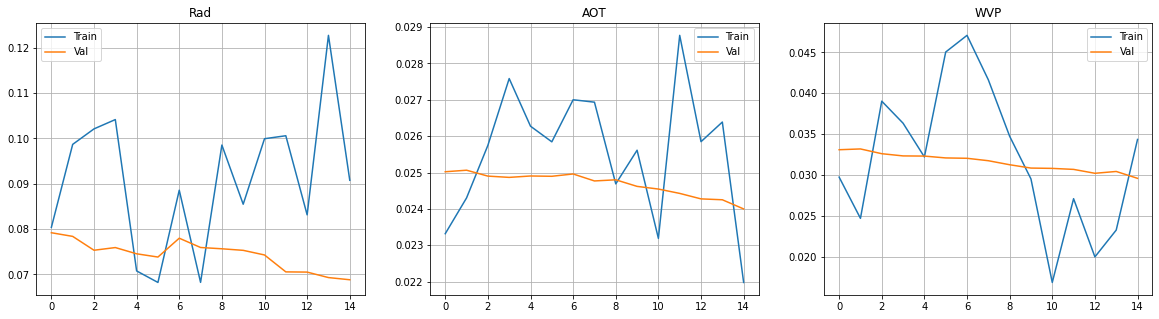

[I 2022-04-09 14:57:28,925] Trial 5 finished with value: 0.0927143469452858 and parameters: {'alpha': 0.12531363020052588, 'beta': 0.7055742568633137, 'lr': 1.7856383981437934e-05}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:32<00:00, 46.15s/it]


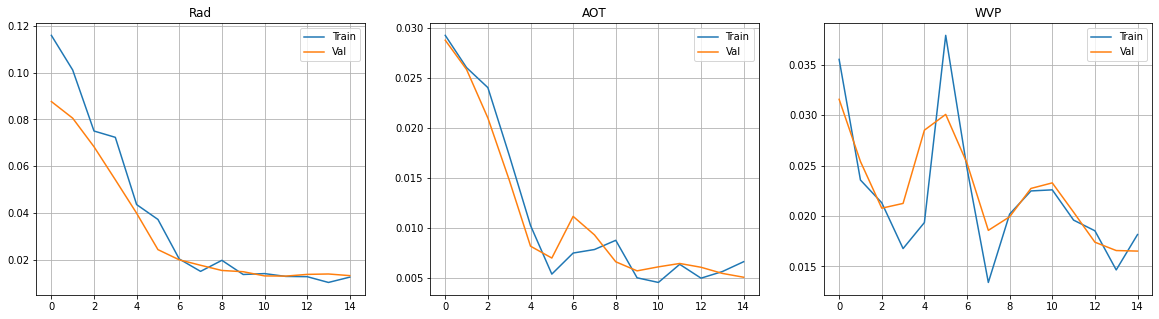

[I 2022-04-09 15:09:01,599] Trial 6 finished with value: 0.028133101761341095 and parameters: {'alpha': 0.4261686981479923, 'beta': 0.7722063000956043, 'lr': 0.00028196589463564157}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:30<00:00, 46.00s/it]


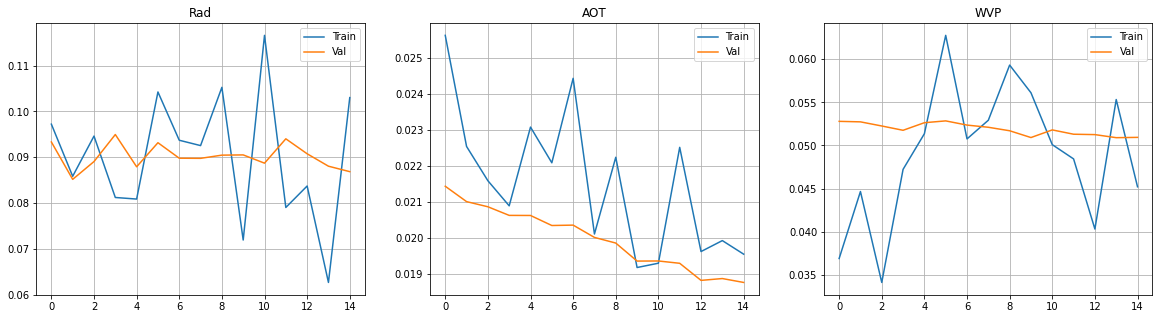

[I 2022-04-09 15:20:32,192] Trial 7 finished with value: 0.13528233766555786 and parameters: {'alpha': 0.9938929501204946, 'beta': 0.5845518637963586, 'lr': 6.027420615343165e-06}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:29<00:00, 45.99s/it]


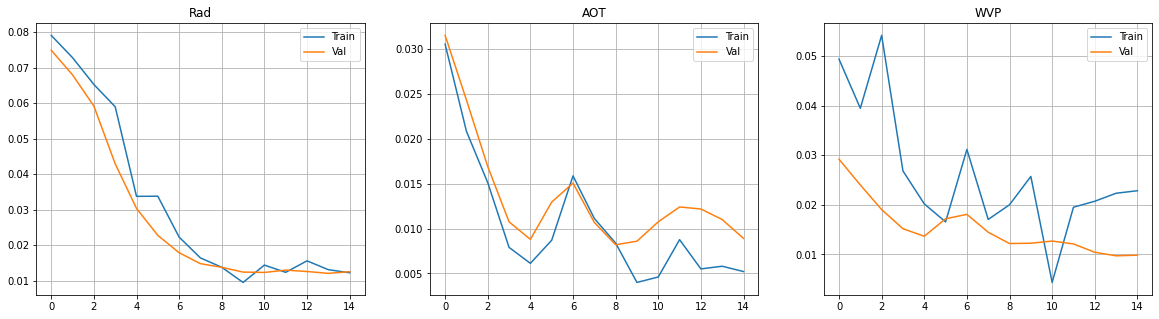

[I 2022-04-09 15:32:02,388] Trial 8 finished with value: 0.024947023019194603 and parameters: {'alpha': 0.8119138063984294, 'beta': 0.5239269211162538, 'lr': 0.000252383138267973}. Best is trial 3 with value: 0.016549628227949142.
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [11:30<00:00, 46.01s/it]


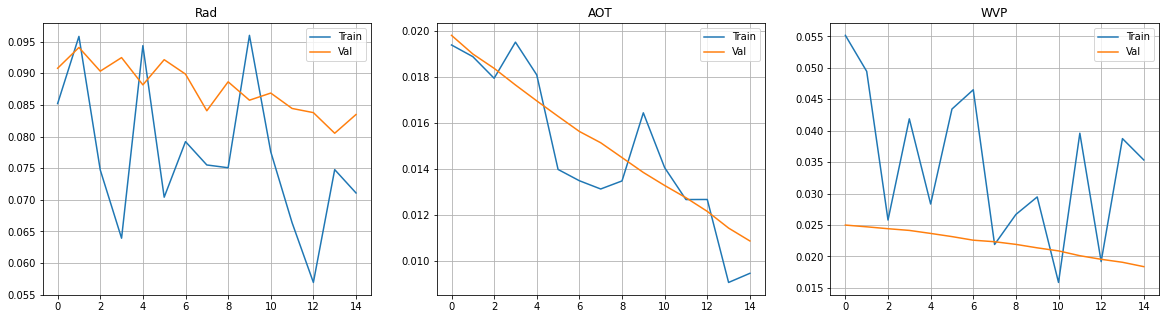

[I 2022-04-09 15:43:32,975] Trial 9 finished with value: 0.10235569626092911 and parameters: {'alpha': 0.8100179226995314, 'beta': 0.5486060254984623, 'lr': 3.517308327311715e-05}. Best is trial 3 with value: 0.016549628227949142.


In [15]:
trial_loss_train = []
trial_loss_val = []


def objective(trial):

    params = {
                'alpha': trial.suggest_float('alpha', 0, 1),
                'beta': trial.suggest_float('beta', 0, 1),
                "lr": trial.suggest_loguniform('lr', 1e-6, 1e-3)
                }

    # initialize our model
    model = FCNN()

    #If we want to load some model weights:

    #model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

    # initialize loss function and optimizer
    lossFunc = MSELoss()
    opt = Adam(model.parameters(), lr=params['lr'])

    # initialize a dictionary to store training history
    H = {"train_loss": [], "val_loss": []}

    # select number of epochs
    num_epochs = 15

    batch_size = 50
    
    window = 256

    df_training = df_train.sample(frac=0.7)
    df_val = df_train.loc[~df_train.index.isin(df_training.index)]

    trainDS = dataset.TiffDataset(df_training, window, True)
    valDS = dataset.TiffDataset(df_val, window, True)

    trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

    # calculate steps per epoch for training and test set
    trainSteps = len(trainLoader)
    valSteps = len(valLoader)

    # loop over epochs
    train_metrics = []
    val_metrics = []
    alpha = params['alpha']
    beta = params['beta']

    for e in tqdm(range(num_epochs)):
        # set the model in training mode
        model.train()

        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0

        # loop over the training set
        for sample in trainLoader:
            # send the input to the device
            x = sample['sl1c']
            y = sample['sl2a']

            # perform a forward pass and calculate the training loss
            pred = model(x)
            train_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
            train_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
            train_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])

            loss = train_rad_loss + alpha*train_aot_loss + beta*train_wvp_loss
            if e == num_epochs-1:
                trial_loss_train.append(train_rad_loss)

            # first, zero out any previously accumulated gradients, then
            # perform backpropagation, and then update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            # add the loss to the total training loss so far
            totalTrainLoss += loss

        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()

            # loop over the validation set
            for sample in valLoader:
                # send the input to the device
                x = sample['sl1c']
                y = sample['sl2a']

                # make the predictions and calculate the validation loss
                pred = model(x)
                val_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
                val_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
                val_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])

                totalValLoss += val_rad_loss + alpha*val_aot_loss + beta*val_wvp_loss
                if e == num_epochs-1:
                    trial_loss_val.append(val_rad_loss)
                
        train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
        train_aot_loss_np = train_aot_loss.cpu().detach().numpy()
        train_wvp_loss_np = train_wvp_loss.cpu().detach().numpy()

        train_metrics.append((train_rad_loss_np, train_aot_loss_np, train_wvp_loss_np))

        val_rad_loss_np = val_rad_loss.cpu().detach().numpy()
        val_aot_loss_np = val_aot_loss.cpu().detach().numpy()
        val_wvp_loss_np = val_wvp_loss.cpu().detach().numpy()

        val_metrics.append((val_rad_loss_np, val_aot_loss_np, val_wvp_loss_np))
        
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        
    train_rad=[]
    train_aot=[]
    train_wvp=[]

    val_rad=[]
    val_aot=[]
    val_wvp=[]

    for i in range(num_epochs):
        train_rad.append(train_metrics[i][0])
        train_aot.append(train_metrics[i][1])
        train_wvp.append(train_metrics[i][2])

        val_rad.append(val_metrics[i][0])
        val_aot.append(val_metrics[i][1])
        val_wvp.append(val_metrics[i][2])

    train_plots = [train_rad, train_aot, train_wvp]
    val_plots = [val_rad, val_aot, val_wvp]
    titles = ['Rad', 'AOT', 'WVP']

    fig, ax = plt.subplots(1,3,figsize=(20,5))

    for i in range(3):
        ax[i].plot(train_plots[i], label='Train')
        ax[i].plot(val_plots[i], label='Val')
        ax[i].set_title(titles[i])
        ax[i].xlabel('Epochs')
        ax[i].ylabel('Loss')
        ax[i].legend()
        ax[i].grid('True')
    
    plt.show()
    
    return totalValLoss

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=15)

In [16]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

alpha: 0.9075653154732716
beta: 0.5301136408744364
lr: 0.000829354460589568


plotejar superfície d'errors amb iteracions per a poder elegir, a banda del model que més minimitze la funcio de perdua en validacio, el model que minimitze més la reflectivitat, encara que els errors de aot i wvp siguen mes grans del que toquen (no importen tant)

plotejar alpha enfront a beta amb iteracions


normalitzar wvp nomes dividint pel maxim (mes facil fer la conversio despres)
normalitzar tambe aot dividint pel maxim

provar a posar un pes a la reflectivitat

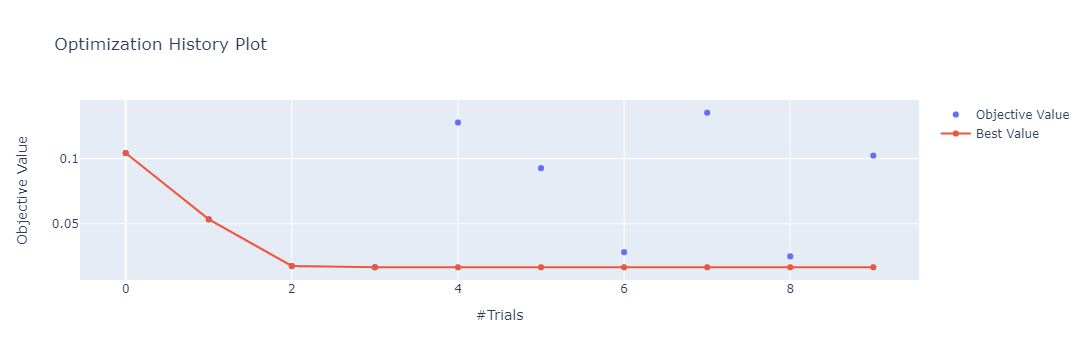

In [17]:
optuna.visualization.plot_optimization_history(study)

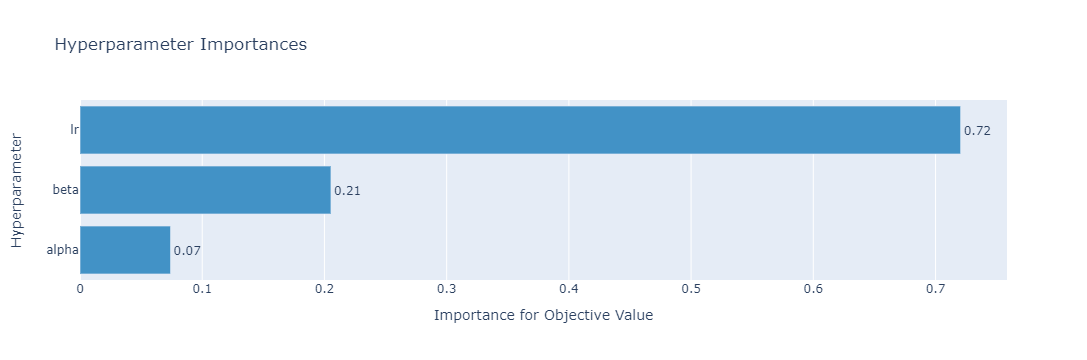

In [18]:
optuna.visualization.plot_param_importances(study)

We will optimize the total loss function, considering reflectance, AOT and WVP, but we will use the parameters that minimize the reflectance overall, even if the separate losses of AOT and WVP are not optimal. We can check this with the following plot. 

In [ ]:
import plotly.graph_objects as go

num_trials = len(study.trials)
val_ref = []
alpha = []
beta = []

for i in range(num_trials):
    val_ref.append(trial_loss_val[i].detach().cpu().numpy())
    alpha.append(study.trials[i].params['alpha'])
    beta.append(study.trials[i].params['beta'])


X = np.array(val_ref)
Y = np.array(alpha)
Z = np.array(beta)

fig = go.Figure(data=[go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(color=X, colorscale='Viridis'))])

fig.update_layout(scene = dict(
                    xaxis_title='Ref',
                    yaxis_title='alpha',
                    zaxis_title='beta'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

Train

In [14]:
# initialize our model
model = FCNN()

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['params']['lr'])

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 20


In [21]:
batch_size = 50

df_training = df_train.sample(frac=0.7)
df_val = df_train.loc[~df_train.index.isin(df_training.index)]

window = 256

trainDS = dataset.TiffDataset(df_training.append(df_training).append(df_training).append(df_training).append(df_training).append(df_training), window, True)
valDS = dataset.TiffDataset(df_val.append(df_val).append(df_val).append(df_val).append(df_val).append(df_val), window, True)

trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

# calculate steps per epoch for training and test set
trainSteps = len(trainLoader)
valSteps = len(valLoader)

/tmp/ipykernel_57329/1428831946.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_57329/1428831946.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_57329/1428831946.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_57329/1428831946.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_57329/1428831946.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_57329/1428831946.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a 

In [22]:
# loop over epochs
train_metrics = []
val_metrics = []
alpha = best_trial.params['alpha']#torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['alpha']
beta = best_trial.params['beta'] #torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['beta']

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for sample in trainLoader:
		# send the input to the device
		x = sample['sl1c']
		y = sample['sl2a']

		# perform a forward pass and calculate the training loss
		pred = model(x)
		train_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
		train_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
		train_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
		loss = train_rad_loss + alpha*train_aot_loss + beta*train_wvp_loss

		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for sample in valLoader:
			# send the input to the device
			x = sample['sl1c']
			y = sample['sl2a']

			# make the predictions and calculate the validation loss
			pred = model(x)
			val_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
			val_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
			val_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
			totalValLoss += val_rad_loss + alpha*val_aot_loss + beta*val_wvp_loss

			

	train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
	train_aot_loss_np = train_aot_loss.cpu().detach().numpy()
	train_wvp_loss_np = train_wvp_loss.cpu().detach().numpy()
	
	train_metrics.append((train_rad_loss_np, train_aot_loss_np, train_wvp_loss_np))

	val_rad_loss_np = val_rad_loss.cpu().detach().numpy()
	val_aot_loss_np = val_aot_loss.cpu().detach().numpy()
	val_wvp_loss_np = val_wvp_loss.cpu().detach().numpy()

	val_metrics.append((val_rad_loss_np, val_aot_loss_np, val_wvp_loss_np))
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print(pd.DataFrame({'rad': [np.around(train_rad_loss_np, decimals=4), np.around(val_rad_loss_np, decimals=4)], 
                        'aot': [np.around(train_aot_loss_np, decimals=4), np.around(val_aot_loss_np, decimals=4)], 
                        'wvp': [np.around(train_wvp_loss_np, decimals=4), np.around(val_wvp_loss_np, decimals=4)]}, ['train', 'val']))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  5%|████                                                                             | 1/20 [04:37<1:27:56, 277.70s/it]

[INFO] EPOCH: 1/20
          rad     aot     wvp
train  0.0133  0.0128  0.0341
val    0.0171  0.0066  0.0158


 10%|████████                                                                         | 2/20 [09:13<1:22:56, 276.48s/it]

[INFO] EPOCH: 2/20
          rad     aot     wvp
train  0.0085  0.0033  0.0042
val    0.0071  0.0084  0.0115


 15%|████████████▏                                                                    | 3/20 [13:49<1:18:19, 276.45s/it]

[INFO] EPOCH: 3/20
         rad     aot     wvp
train  0.008  0.0049  0.0081
val    0.006  0.0038  0.0068


 20%|████████████████▏                                                                | 4/20 [18:23<1:13:28, 275.56s/it]

[INFO] EPOCH: 4/20
          rad     aot     wvp
train  0.0053  0.0067  0.0072
val    0.0048  0.0066  0.0064


 25%|████████████████████▎                                                            | 5/20 [22:58<1:08:47, 275.15s/it]

[INFO] EPOCH: 5/20
          rad     aot     wvp
train  0.0043  0.0023  0.0033
val    0.0046  0.0027  0.0038


 30%|████████████████████████▎                                                        | 6/20 [27:35<1:04:19, 275.69s/it]

[INFO] EPOCH: 6/20
          rad     aot     wvp
train  0.0030  0.0033  0.0020
val    0.0036  0.0034  0.0019


 35%|█████████████████████████████                                                      | 7/20 [32:09<59:36, 275.12s/it]

[INFO] EPOCH: 7/20
          rad     aot     wvp
train  0.0036  0.0027  0.0016
val    0.0029  0.0054  0.0018


 40%|█████████████████████████████████▏                                                 | 8/20 [36:42<54:54, 274.58s/it]

[INFO] EPOCH: 8/20
          rad     aot     wvp
train  0.0028  0.0032  0.0014
val    0.0024  0.0044  0.0006


 45%|█████████████████████████████████████▎                                             | 9/20 [41:16<50:20, 274.55s/it]

[INFO] EPOCH: 9/20
          rad     aot     wvp
train  0.0024  0.0027  0.0015
val    0.0027  0.0045  0.0017


 50%|█████████████████████████████████████████                                         | 10/20 [45:52<45:49, 274.96s/it]

[INFO] EPOCH: 10/20
          rad     aot     wvp
train  0.0023  0.0023  0.0015
val    0.0015  0.0024  0.0006


 55%|█████████████████████████████████████████████                                     | 11/20 [50:27<41:14, 274.96s/it]

[INFO] EPOCH: 11/20
          rad     aot     wvp
train  0.0032  0.0019  0.0009
val    0.0010  0.0046  0.0025


 60%|█████████████████████████████████████████████████▏                                | 12/20 [55:00<36:35, 274.39s/it]

[INFO] EPOCH: 12/20
          rad     aot     wvp
train  0.0023  0.0018  0.0014
val    0.0020  0.0024  0.0006


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [59:36<32:02, 274.66s/it]

[INFO] EPOCH: 13/20
          rad     aot     wvp
train  0.0013  0.0027  0.0013
val    0.0019  0.0035  0.0005


 70%|████████████████████████████████████████████████████████                        | 14/20 [1:04:10<27:26, 274.47s/it]

[INFO] EPOCH: 14/20
          rad     aot     wvp
train  0.0020  0.0018  0.0008
val    0.0013  0.0018  0.0019


 75%|████████████████████████████████████████████████████████████                    | 15/20 [1:08:44<22:51, 274.31s/it]

[INFO] EPOCH: 15/20
          rad     aot     wvp
train  0.0014  0.0028  0.0005
val    0.0017  0.0022  0.0009


 80%|████████████████████████████████████████████████████████████████                | 16/20 [1:13:19<18:18, 274.69s/it]

[INFO] EPOCH: 16/20
          rad     aot     wvp
train  0.0014  0.0022  0.0006
val    0.0019  0.0043  0.0006


 85%|████████████████████████████████████████████████████████████████████            | 17/20 [1:17:52<13:42, 274.22s/it]

[INFO] EPOCH: 17/20
          rad     aot     wvp
train  0.0018  0.0023  0.0008
val    0.0018  0.0027  0.0005


 90%|████████████████████████████████████████████████████████████████████████        | 18/20 [1:22:26<09:08, 274.01s/it]

[INFO] EPOCH: 18/20
          rad     aot     wvp
train  0.0024  0.0015  0.0005
val    0.0015  0.0040  0.0012


 95%|████████████████████████████████████████████████████████████████████████████    | 19/20 [1:27:00<04:34, 274.12s/it]

[INFO] EPOCH: 19/20
          rad     aot     wvp
train  0.0013  0.0021  0.0007
val    0.0010  0.0028  0.0006


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [1:31:35<00:00, 274.78s/it]

[INFO] EPOCH: 20/20
          rad     aot     wvp
train  0.0015  0.0008  0.0006
val    0.0009  0.0048  0.0009
[INFO] total time taken to train the model: 5495.70s


Evaluate predictions

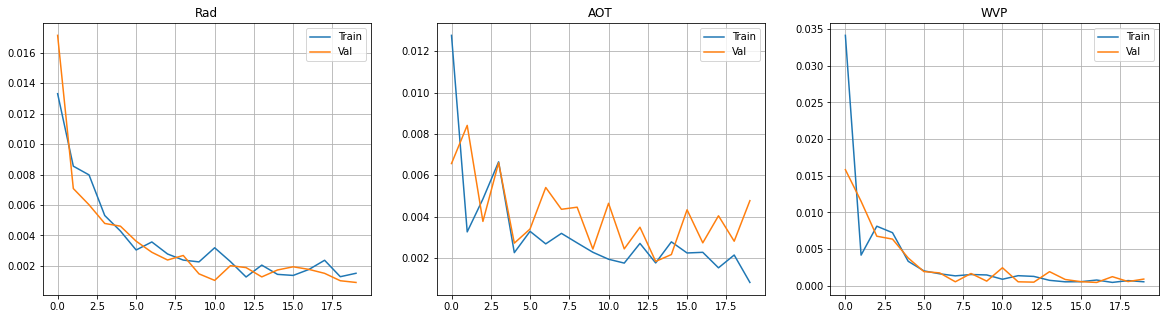

In [23]:
train_rad=[]
train_aot=[]
train_wvp=[]

val_rad=[]
val_aot=[]
val_wvp=[]
for i in range(num_epochs):
    train_rad.append(train_metrics[i][0])
    train_aot.append(train_metrics[i][1])
    train_wvp.append(train_metrics[i][2])

    val_rad.append(val_metrics[i][0])
    val_aot.append(val_metrics[i][1])
    val_wvp.append(val_metrics[i][2])

train_plots = [train_rad, train_aot, train_wvp]
val_plots = [val_rad, val_aot, val_wvp]
titles = ['Rad', 'AOT', 'WVP']

fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(3):
    ax[i].plot(train_plots[i], label='Train')
    ax[i].plot(val_plots[i], label='Val')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid('True')

Global metrics

RMSE and PSNR for each band averaged for the complete test set:

In [18]:
test = dataset.TiffDataset(df_test, 256, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()

BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']
rmse_total = 0
psnr_total = 0

for j in range(len(test)):
    item = test[j]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    rmse_pred = []
    psnr_pred = []
    for i in range(len(preds[0])):
        rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
        psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

        rmse_pred.append(rmse.detach().numpy())
        psnr_pred.append(psnr.detach().numpy())
    
    rmse_total += np.array(rmse_pred)
    psnr_total += np.array(psnr_pred)

RMSE = rmse_total / len(test)
PSNR = psnr_total / len(test)

pd.DataFrame(np.concatenate((RMSE,PSNR)).reshape(2,14), methods, BANDS_L2A)

B1         B2         B3         B4         B5         B6  \
RMSE   0.031848   0.032273   0.029599   0.034455   0.031415   0.031860   
PSNR  20.317612  22.862928  25.347586  24.555244  26.198553  26.984152   

             B7         B8        B8A         B9        B11        B12  \
RMSE   0.033569   0.038999   0.034567   0.040560   0.025908   0.025141   
PSNR  26.915312  25.827274  26.753902  24.750868  26.096512  25.336893   

           AOT        WVP  
RMSE  0.278559   0.021507  
PSNR  0.526042  22.158924

Individual metrics (choose id)

RMSE and PSNR for an individual sample of the test set:

In [18]:
test = dataset.TiffDataset(df_test, 256, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()
rmse_pred = []
psnr_pred = []
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']


for i in range(len(preds[0])):
    rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
    psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

    rmse_pred.append(rmse.detach().numpy())
    psnr_pred.append(psnr.detach().numpy())

print('Id:', idx)
pd.DataFrame(np.concatenate((np.array(rmse_pred),np.array(psnr_pred))).reshape(2,14), methods, BANDS_L2A)

Id: 72


B1         B2         B3         B4         B5         B6  \
RMSE   0.018000   0.012650   0.022684   0.018611   0.026195   0.056801   
PSNR  12.495129  19.538635  17.695456  21.191383  19.265953  17.476894   

             B7         B8        B8A         B9        B11        B12  \
RMSE   0.066368   0.069656   0.071195   0.069509   0.046385   0.031310   
PSNR  17.545485  17.459484  17.339424  17.361740  18.437864  19.879091   

           AOT        WVP  
RMSE  0.130881   0.024236  
PSNR  3.704152  20.929253

The following plot displays the ratio between **prediction - real value** of a series of pixels (1000) from the test set images and for each band separately.

Text(0.5, 1.0, 'Pixel ratio of predicted vs real values for the test set')

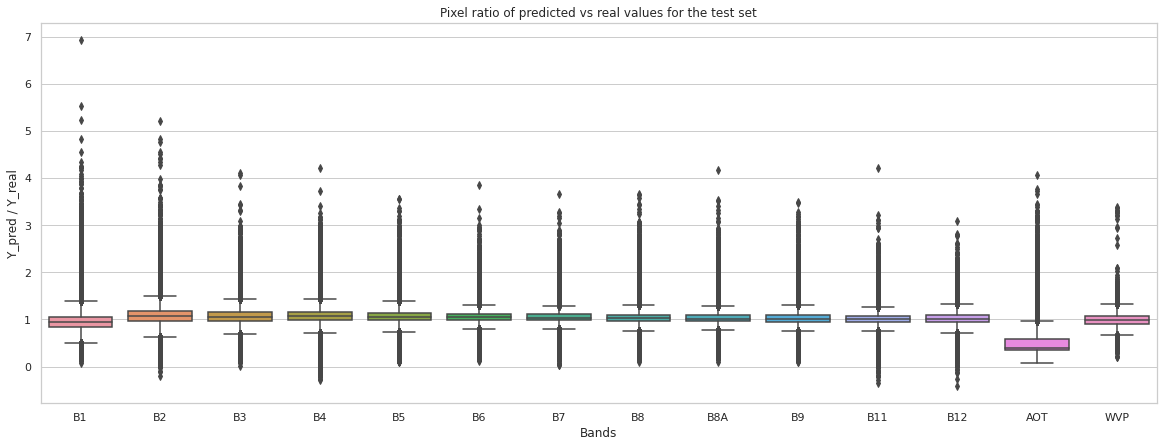

In [44]:
import seaborn as sns
boxplot = {}
boxplot["band"] = []
boxplot["val"] = []
out = np.zeros(preds.shape[1])
samples = 1000

for sample in range(len(test)):
    test = dataset.TiffDataset(df_test, 256, False)
    #id = np.random.randint(0, len(test))
    item = test[sample]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    for sample in range(samples):
        idx = np.random.randint(0, preds.shape[2])
        idy = np.random.randint(0, preds.shape[3])
        for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot["band"].append(BANDS_L2A[band])
                boxplot["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out[band] += 1
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot["band"], y=boxplot["val"], order=BANDS_L2A)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set_title('Pixel ratio of predicted vs real values for the test set')

In [46]:
out/(len(test)*samples) #Ratio of samples with real values < 0.05 for each band

array([0.46724096, 0.38491566, 0.17875904, 0.23109639, 0.03984337,
       0.01526506, 0.01378313, 0.01528916, 0.01495181, 0.01178313,
       0.03480723, 0.07161446, 0.01204819, 0.1826747 ])

66


Text(0.5, 1.0, 'Pixel ratio of predicted vs real values for test image: 66')

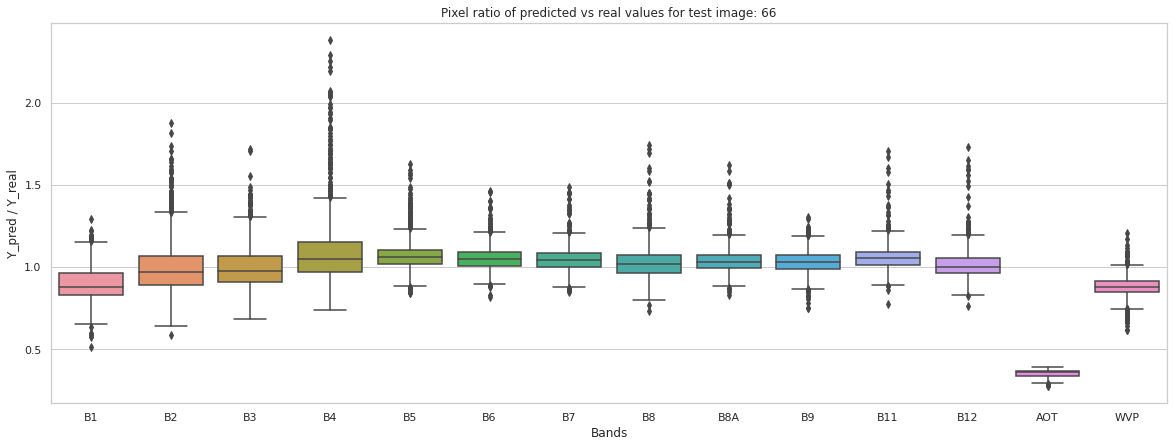

In [50]:
boxplot_2 = {}
boxplot_2["band"] = []
boxplot_2["val"] = []
out_2 = np.zeros(preds.shape[1])
samples = 1000

test = dataset.TiffDataset(df_test, 256, False)
idn = np.random.randint(0, len(test))
print(idn)
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

for sample in range(samples):
    idx = np.random.randint(0, preds.shape[2])
    idy = np.random.randint(0, preds.shape[3])
    for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot_2["band"].append(BANDS_L2A[band])
                boxplot_2["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out_2[band] += 1
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot_2["band"], y=boxplot_2["val"], order=BANDS_L2A)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set_title('Pixel ratio of predicted vs real values for test image: {}'.format(idn))

In [51]:
out_2/samples #Ratio of samples with real values < 0.05 for each band

array([0.091, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

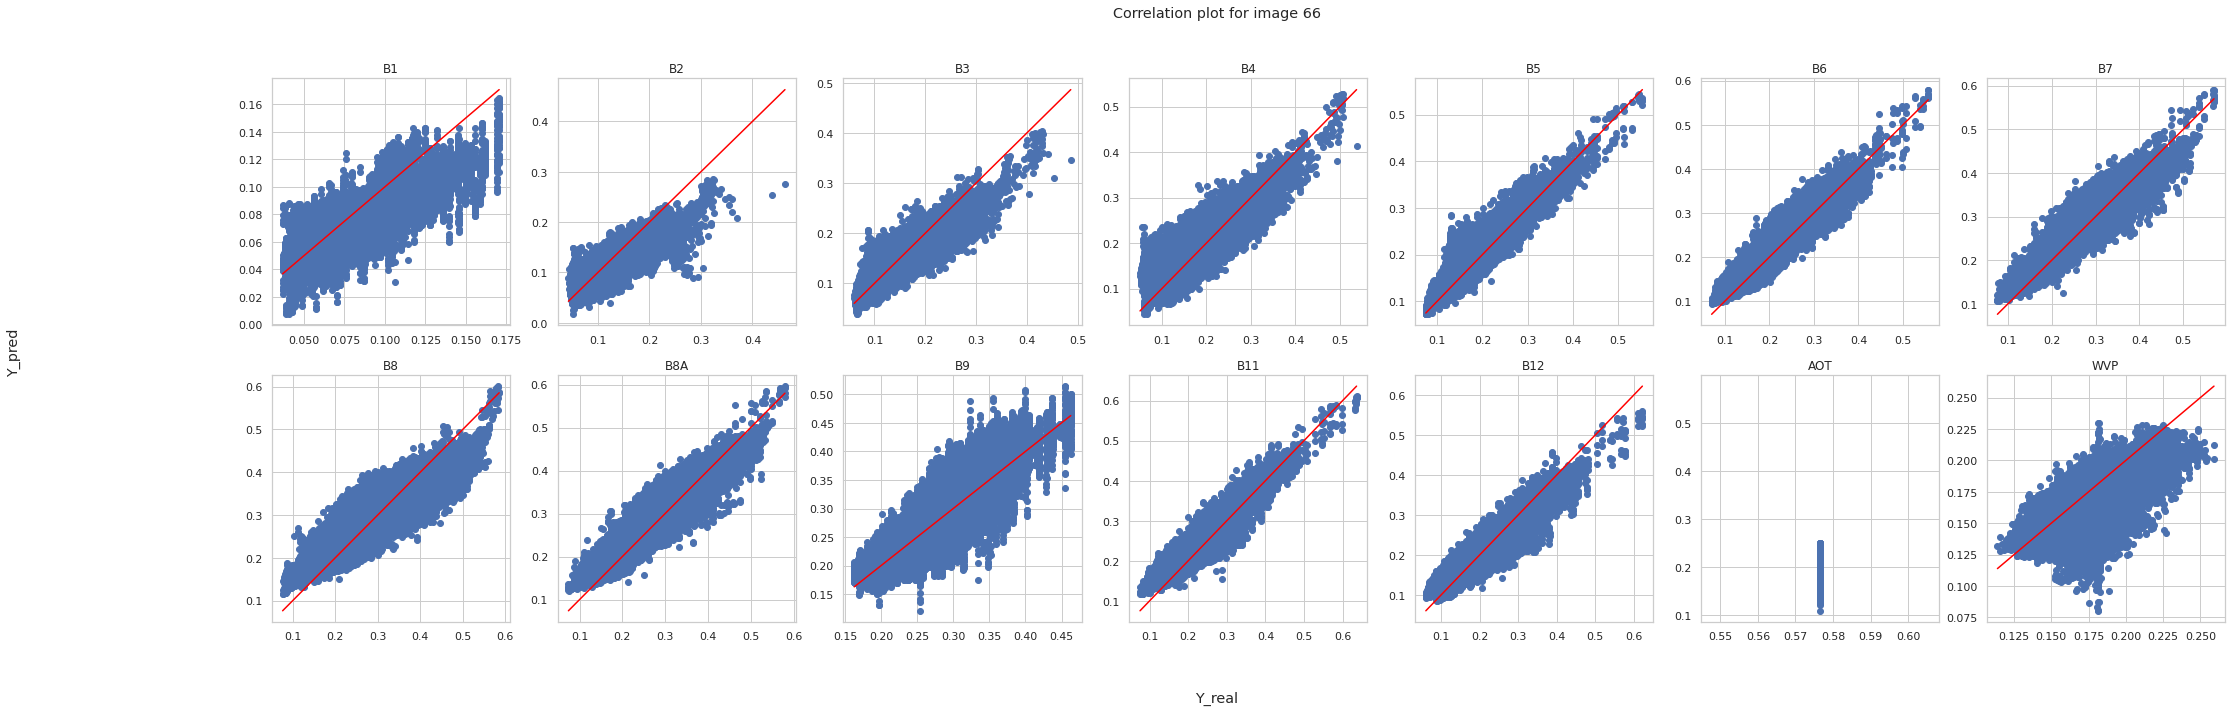

In [52]:
test = dataset.TiffDataset(df_test, 256, False)
#idn = np.random.randint(0, len(test))
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']


fig, axs = plt.subplots(2,7,figsize=(35,10))
band=1

for band in range(int(len(BANDS_L2A)/2)):
    axs[0, band].plot( [item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()],[item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()], c='red' )
    axs[1, band].plot( [item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().min(),item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().max()],[item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().min(),item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().max()], c='red')
    axs[0, band].scatter(item['sl2a'][band].cpu().detach().numpy(), preds[0][band].cpu().detach().numpy())
    axs[0, band].set_title(BANDS_L2A[band])
    axs[1, band].scatter(item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy(), preds[0][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy())
    axs[1, band].set_title(BANDS_L2A[band+int(len(BANDS_L2A)/2)])

fig.supxlabel('Y_real')
fig.supylabel('Y_pred')
    

plt.suptitle('Correlation plot for image {0}'.format(idn))
plt.show()

Plot predictions

Text(0.5, 1.0, 'Pred')

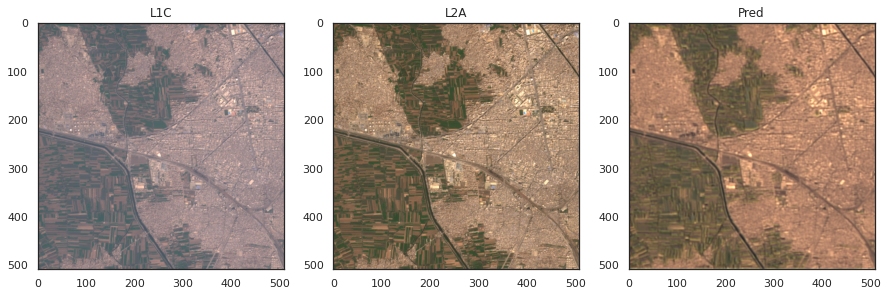

In [53]:
sns.set_theme(style="white")

test = dataset.TiffDataset(df_test, 256, False)
idx = idn#np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")

ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")
ax[2].imshow(predic)
ax[2].set_title("Pred")

Finally, we can save the trained model weights and optimized hyperparameters to use them in the future

In [27]:
model_save = {'state_dict': model.state_dict(), 'params': best_trial.params}

#torch.save(model_save, 'saved_models/fcnn_e20_batch50_model_save.pth') 

Load previously saved model weights

In [16]:
#model.load_state_dict(torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['state_dict'])

<All keys matched successfully>